# Async Analysis of EGHG Data Streams

In [31]:
import sys
sys.path.insert(0, '..')

import asyncio
import json
import collections
import math

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['figure.dpi'] = 70 # 200 e.g. is really fine, but slower

from random import randrange

from jupyterplot import ProgressPlot

import pandas as pd

from eghg_analyzer.streaming import remote_stream, local_stream

# This is a flag for disabling all networking features from this notebook
# If disabled, cells with networking parts will use some pre-recorded
# data and act like it is coming from a network source.
ENABLE_NETWORKING = False

## Settings

In [32]:
# The size of the queue used for processing input. This is the number of last snapshots
# that are available at most.
current_data_size = 200

# The window size for moving average calculations.
moving_average_window = 10

# How many frames the fixation algorithm will look back
fixation_lookback = 15

# What function f(x), where x is the lookback index, will be applied to the distance value
fixation_lookback_decay = lambda x: 1 / math.sqrt(0.25*x + 1)

# The angular fixation range is the range that is always considered to be fixed
fixation_range = 5

# Selection
selection_lookback = 40 # Number of frames to look back for finding selections
selection_tolerance = 150 # Tolerance for the x-acceleration mean and target
selection_target_acceleration = 600
selection_fixation = 0.7
selection_quantile = 0.5

## Network Connection and Parsing
The following code is used for opening and handling a network connection to the unity data provider and process the packets encoded as JSON objects.

In [39]:
ip = "127.0.0.1"
port = 9060
offline_recording = "../data/recording-example.json"

if ENABLE_NETWORKING:
    data_stream = remote_stream
    data_stream.setup_stream(ip=ip, port=port)
else:
    data_stream = local_stream
    data_stream.setup_stream(file=offline_recording)

In [40]:
current_data = collections.deque([], current_data_size)
task = data_stream.get_stream(current_data)

In [41]:
if len(current_data) > 0:
    print(current_data[-1])
print(f'Length: {len(current_data)}')

{'headGaze': {'x': 0.03487822785973549, 'y': -0.034878235310316086, 'z': 0.0012179745826870203, 'w': 0.9987820386886597}, 'eyeGaze': {'x': -0.017232881858944893, 'y': -0.023349016904830933, 'z': -0.0016102114459499717, 'w': 0.9995775818824768}, 'headWorldPosition': {'x': 0.0, 'y': 0.20000000298023224, 'z': 0.0}, 'headRotation': {'x': -0.03487823158502579, 'y': 0.034878235310316086, 'z': -0.0012179736513644457, 'w': -0.9987820386886597}}
Length: 44


`msgs` is an async_generator which can be iterated for getting the EGHG streamed data

In [42]:
data_stream.stop_stream(task)

## List Conversion and Pandas Dataframe
In order to use the data we need the data available as a parsable object. `get_remote_stream` processes the async_generator and puts it into a Python `deque`, which acts as a shift register which always has the last `current_data_size` entries as a container than can be iterated.

Using Pandas, this data can be parsed and organized in a dataframe.

In [43]:
df = pd.json_normalize(current_data)
df.head()

,headGaze.x,headGaze.y,headGaze.z,headGaze.w,eyeGaze.x,eyeGaze.y,eyeGaze.z,eyeGaze.w,headWorldPosition.x,headWorldPosition.y,headWorldPosition.z,headRotation.x,headRotation.y,headRotation.z,headRotation.w
0,0.034878,-0.034878,0.001218,0.998782,-0.017233,-0.023349,-0.00161,0.999578,0.0,0.2,0.0,-0.034878,0.034878,-0.001218,-0.998782
1,0.034878,-0.034878,0.001218,0.998782,-0.017233,-0.023349,-0.00161,0.999578,0.0,0.2,0.0,-0.034878,0.034878,-0.001218,-0.998782
2,0.034878,-0.034878,0.001218,0.998782,-0.017233,-0.023349,-0.00161,0.999578,0.0,0.2,0.0,-0.034878,0.034878,-0.001218,-0.998782
3,0.034878,-0.034878,0.001218,0.998782,-0.017233,-0.023349,-0.00161,0.999578,0.0,0.2,0.0,-0.034878,0.034878,-0.001218,-0.998782
4,0.034878,-0.034878,0.001218,0.998782,-0.017233,-0.023349,-0.00161,0.999578,0.0,0.2,0.0,-0.034878,0.034878,-0.001218,-0.998782


## Extend Data

For better usability, dataframes will be augmented with additional and derived data.

In [44]:
def eghg(): pass # eghg namespaced

### Euler Angles

In [45]:
# Turns a quaternion into euler angles based on the forward direction
def quaternion_to_euler_angle(w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.degrees(np.arctan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = np.where(t2>+1.0,+1.0,t2)
    #t2 = +1.0 if t2 > +1.0 else t2

    t2 = np.where(t2<-1.0, -1.0, t2)
    #t2 = -1.0 if t2 < -1.0 else t2
    Y = np.degrees(np.arcsin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.degrees(np.arctan2(t3, t4))

    return X, Y, Z

In [46]:
def eghg_augment_cartesian_angles(df):
    df[["headGaze.cartesian.y", "headGaze.cartesian.x", "headGaze.cartesian.z"]] = df.apply(
        lambda row:
            quaternion_to_euler_angle(row["headGaze.w"], row["headGaze.x"], row["headGaze.y"], row["headGaze.z"])
        , axis=1, result_type='expand')
    df[["eyeGaze.cartesian.y", "eyeGaze.cartesian.x", "eyeGaze.cartesian.z"]] = df.apply(
        lambda row:
            quaternion_to_euler_angle(row["eyeGaze.w"], row["eyeGaze.x"], row["eyeGaze.y"], row["eyeGaze.z"])
        , axis=1, result_type='expand')

eghg.augment_cartesian_angles = eghg_augment_cartesian_angles

# Visualisation

Visualization of Head- and Eye-Gaze.

<IPython.core.display.Javascript object>


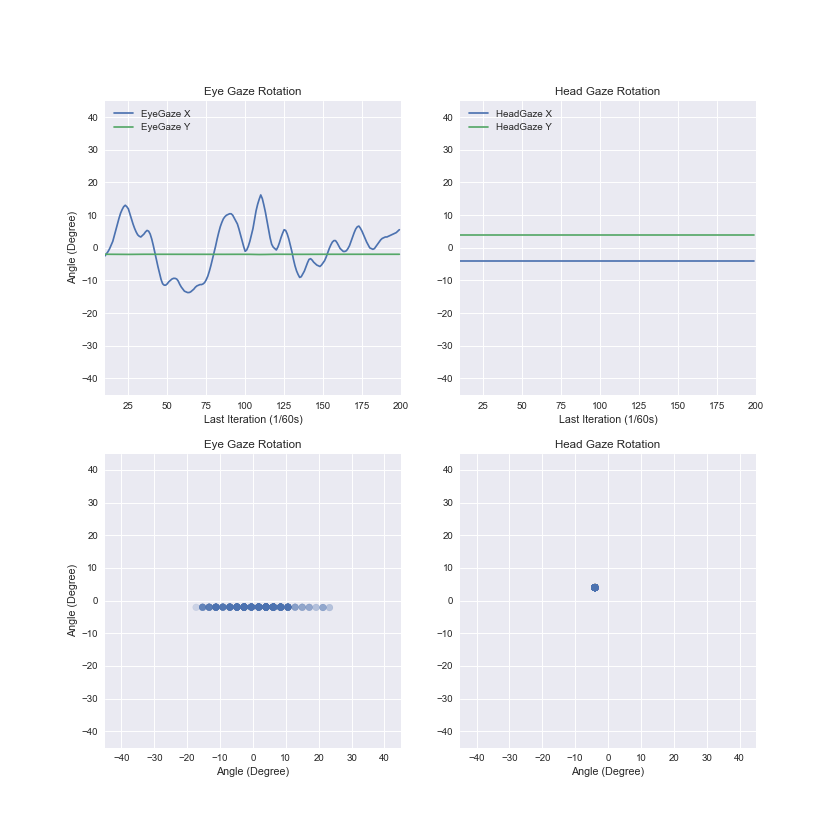

In [47]:
#hideme

# Streaming
current_data = collections.deque([], current_data_size)
task = data_stream.get_stream(current_data)


def on_close(evt):
    data_stream.stop_stream(task)


# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.canvas.mpl_connect('close_event', on_close)


line1, = ax[0][0].plot([], [], label="EyeGaze X", linestyle='-')
line2, = ax[0][0].plot([], [], label="EyeGaze Y", linestyle='-')
line3, = ax[0][1].plot([], [], label="HeadGaze X", linestyle='-')
line4, = ax[0][1].plot([], [], label="HeadGaze Y", linestyle='-')

intensity = np.geomspace(0.1, 1, current_data_size)
line5 = ax[1][0].scatter([], [], label="EyeGaze X/Y", alpha=intensity, vmin=-45, vmax=45)
line6 = ax[1][1].scatter([], [], label="HeadGaze X/Y", alpha=intensity, vmin=-45, vmax=45)

ax[0][0].set_title("Eye Gaze Rotation")
ax[0][0].legend(loc="upper left")

ax[0][1].set_title("Head Gaze Rotation")
ax[0][1].legend(loc="upper left")

ax[1][0].set_title("Eye Gaze Rotation")
ax[1][1].set_title("Head Gaze Rotation")

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    
    ax[0][0].set_xlim(moving_average_window, 200)
    ax[0][0].set_ylim(-45, 45)
    ax[0][1].set_xlim(moving_average_window, 200)
    ax[0][1].set_ylim(-45, 45)
    
    ax[0][0].set_ylabel("Angle (Degree)")
    ax[0][0].set_xlabel("Last Iteration (1/60s)")
    ax[0][1].set_xlabel("Last Iteration (1/60s)")
        
    ax[1][0].set_xlim(-45, 45)
    ax[1][0].set_ylim(-45, 45)
    ax[1][0].set_ylabel("Angle (Degree)")
    ax[1][0].set_xlabel("Angle (Degree)")
    
    ax[1][1].set_xlim(-45, 45)
    ax[1][1].set_ylim(-45, 45)
    ax[1][1].set_xlabel("Angle (Degree)")


last_ex = None
def update(frame):
    try:
        if len(current_data) > 0:
            df = pd.json_normalize(current_data)
            eghg.augment_cartesian_angles(df)
            line1.set_data(df.index, df["eyeGaze.cartesian.x"].rolling(moving_average_window).mean())
            line2.set_data(df.index, df["eyeGaze.cartesian.y"].rolling(moving_average_window).mean())
            line3.set_data(df.index, df["headGaze.cartesian.x"].rolling(moving_average_window).mean())
            line4.set_data(df.index, df["headGaze.cartesian.y"].rolling(moving_average_window).mean())

            line5.set_offsets(np.c_[df["eyeGaze.cartesian.x"], df["eyeGaze.cartesian.y"]])
            line6.set_offsets(np.c_[df["headGaze.cartesian.x"], df["headGaze.cartesian.y"]])
            
            ax[1][0].set_xlim(-45, 45)
            ax[1][0].set_ylim(-45, 45)
            ax[1][1].set_xlim(-45, 45)
            ax[1][1].set_ylim(-45, 45)
    except:
        pass



animation = FuncAnimation(fig, update, init_func=init, interval=200, blit=True)
plt.show()

## Distances

Calculate the distances between head and eye gaze, in degrees.

In [48]:
def eghg_augment_distances(df):
    df["eyeGazeHeadGaze.distance.x"] = (df["eyeGaze.cartesian.x"] - df["headGaze.cartesian.x"]).rolling(moving_average_window).mean()
    df["eyeGazeHeadGaze.distance.y"] = (df["eyeGaze.cartesian.y"] - df["headGaze.cartesian.y"]).rolling(moving_average_window).mean()
    df["eyeGazeHeadGaze.distance"] = np.sqrt(df["eyeGazeHeadGaze.distance.x"] ** 2 + df["eyeGazeHeadGaze.distance.y"] ** 2)


eghg.augment_distances = eghg_augment_distances

## Forces

Calculate "forces" as velocity and acceleration which are derived from the position.

In [49]:
def eghg_augment_forces(df):
    # HeadGaze
    df[["headGaze.cartesian.y_velocity", "headGaze.cartesian.x_velocity"]] = \
        df[["headGaze.cartesian.y", "headGaze.cartesian.x"]].rolling(moving_average_window).mean().diff().fillna(0) / (1/60)
    df[["headGaze.cartesian.y_acceleration", "headGaze.cartesian.x_acceleration"]] = \
        df[["headGaze.cartesian.y_velocity", "headGaze.cartesian.x_velocity"]].rolling(moving_average_window).mean().diff().fillna(0) / (1/60)
    
    # Eye Gaze
    df[["eyeGaze.cartesian.y_velocity", "eyeGaze.cartesian.x_velocity"]] = \
        df[["eyeGaze.cartesian.y", "eyeGaze.cartesian.x"]].rolling(moving_average_window).mean().diff().fillna(0) / (1/60)
    df[["eyeGaze.cartesian.y_acceleration", "eyeGaze.cartesian.x_acceleration"]] = \
        df[["eyeGaze.cartesian.y_velocity", "eyeGaze.cartesian.x_velocity"]].rolling(moving_average_window).mean().diff().fillna(0) / (1/60)
    
    # Head Eye Gaze Distance
    df[["eyeGazeHeadGaze.distance.y_velocity", "eyeGazeHeadGaze.distance.x_velocity"]] = \
        df[["eyeGazeHeadGaze.distance.y", "eyeGazeHeadGaze.distance.x"]].rolling(moving_average_window).mean().diff().fillna(0) / (1/60)
    df[["eyeGazeHeadGaze.distance.y_acceleration", "eyeGazeHeadGaze.distance.x_acceleration"]] = \
        df[["eyeGazeHeadGaze.distance.y_velocity", "eyeGazeHeadGaze.distance.x_velocity"]].rolling(moving_average_window).mean().diff().fillna(0) / (1/60)


eghg.augment_forces = eghg_augment_forces

Visualisation of both acceleration and velocity on the X axis for Eye- and Head-Gaze.

<IPython.core.display.Javascript object>


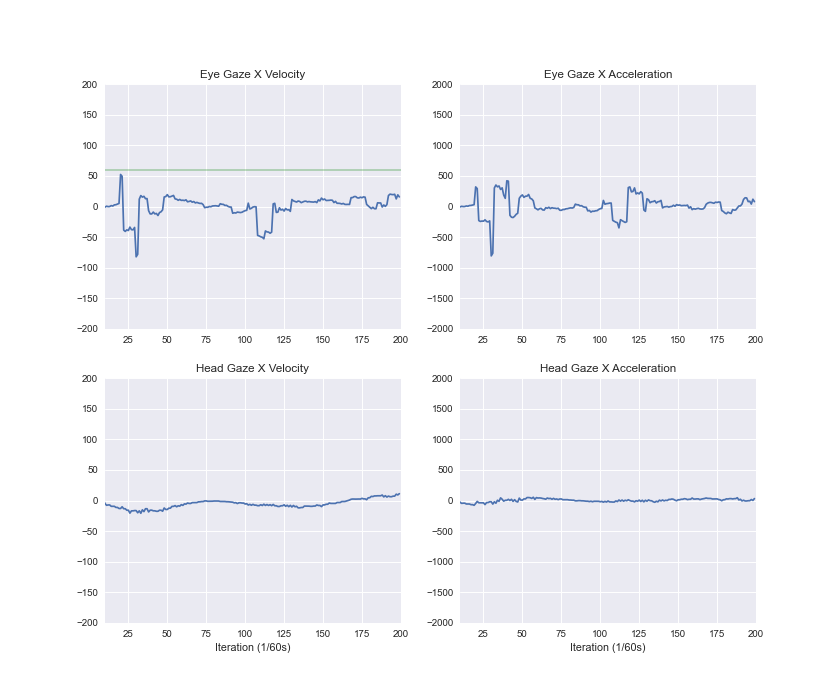

In [15]:
# Streaming
current_data = collections.deque([], current_data_size)
task = data_stream.get_stream(current_data)


def on_close(evt):
    data_stream.stop_stream(task)


# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.canvas.mpl_connect('close_event', on_close)

line1, = ax[0][0].plot([], [], label="X Velocity", linestyle='-')
ax[0][0].axhline(60, color='green', lw=2, alpha=0.25)

line2, = ax[0][1].plot([], [], label="X Acceleration", linestyle='-')
line3, = ax[1][0].plot([], [], label="X Velocity", linestyle='-')
line4, = ax[1][1].plot([], [], label="X Acceleration", linestyle='-')

ax[0][0].set_title("Eye Gaze X Velocity")
ax[0][1].set_title("Eye Gaze X Acceleration")
ax[1][0].set_title("Head Gaze X Velocity")
ax[1][1].set_title("Head Gaze X Acceleration")


def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    
    ax[0][0].set_xlim(moving_average_window, 200)
    ax[0][0].set_ylim(-200, 200)
    ax[0][1].set_xlim(moving_average_window, 200)
    ax[0][1].set_ylim(-2000, 2000)    
    ax[1][0].set_xlim(moving_average_window, 200)
    ax[1][0].set_ylim(-200, 200)
    ax[1][1].set_xlim(moving_average_window, 200)
    ax[1][1].set_ylim(-2000, 2000)

    ax[1][0].set_xlabel("Iteration (1/60s)")
    ax[1][1].set_xlabel("Iteration (1/60s)")


def update(frame):
    try:
        if len(current_data) > 0:
            df = pd.json_normalize(current_data)
            eghg.augment_cartesian_angles(df)
            eghg.augment_distances(df)
            eghg.augment_forces(df)
            line1.set_data(df.index, df["eyeGaze.cartesian.x_velocity"])
            line2.set_data(df.index, df["eyeGaze.cartesian.x_acceleration"])
            line3.set_data(df.index, df["headGaze.cartesian.x_velocity"])
            line4.set_data(df.index, df["headGaze.cartesian.x_acceleration"])
            
            ax[0][0].collections.clear()
            line1_fill = ax[0][0].fill_between(df.index, -200, 200, where=df["eyeGaze.cartesian.x_velocity"] > 60,
                color='green', alpha=0.5, transform=ax[0][0].get_xaxis_transform())
            
            return line1, line2, line3, line4, line1_fill,
    except:
        pass


animation = FuncAnimation(fig, update, init_func=init, interval=200, blit=True)
plt.show()

Visualisation of acceleration and velocity for the distance between Eye- and Head-Gaze.

<IPython.core.display.Javascript object>


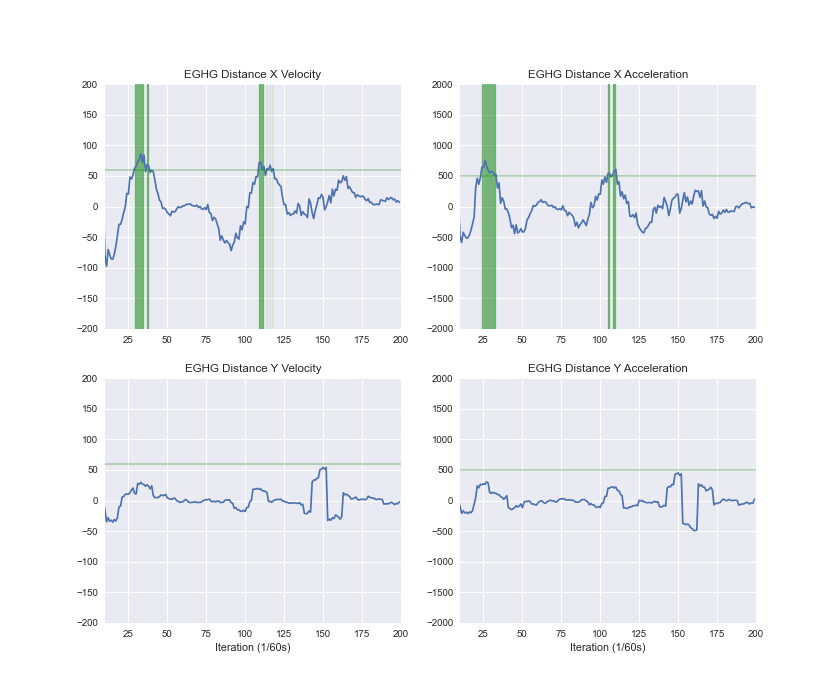

In [16]:
# Streaming
current_data = collections.deque([], current_data_size)
task = data_stream.get_stream(current_data)


def on_close(evt):
    data_stream.stop_stream(task)


# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.canvas.mpl_connect('close_event', on_close)

line1, = ax[0][0].plot([], [], label="X Velocity", linestyle='-')
ax[0][0].axhline(60, color='green', lw=2, alpha=0.25)

line2, = ax[0][1].plot([], [], label="X Acceleration", linestyle='-')
ax[0][1].axhline(500, color='green', lw=2, alpha=0.25)

line3, = ax[1][0].plot([], [], label="Y Velocity", linestyle='-')
ax[1][0].axhline(60, color='green', lw=2, alpha=0.25)

line4, = ax[1][1].plot([], [], label="Y Acceleration", linestyle='-')
ax[1][1].axhline(500, color='green', lw=2, alpha=0.25)

ax[0][0].set_title("EGHG Distance X Velocity")
ax[0][1].set_title("EGHG Distance X Acceleration")
ax[1][0].set_title("EGHG Distance Y Velocity")
ax[1][1].set_title("EGHG Distance Y Acceleration")


def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    
    ax[0][0].set_xlim(moving_average_window, 200)
    ax[0][0].set_ylim(-200, 200)
    ax[0][1].set_xlim(moving_average_window, 200)
    ax[0][1].set_ylim(-2000, 2000)    
    ax[1][0].set_xlim(moving_average_window, 200)
    ax[1][0].set_ylim(-200, 200)
    ax[1][1].set_xlim(moving_average_window, 200)
    ax[1][1].set_ylim(-2000, 2000)

    ax[1][0].set_xlabel("Iteration (1/60s)")
    ax[1][1].set_xlabel("Iteration (1/60s)")


def update(frame):
    try:
        if len(current_data) > 0:
            df = pd.json_normalize(current_data)
            eghg.augment_cartesian_angles(df)
            eghg.augment_distances(df)
            eghg.augment_forces(df)
            line1.set_data(df.index, df["eyeGazeHeadGaze.distance.x_velocity"])
            line2.set_data(df.index, df["eyeGazeHeadGaze.distance.x_acceleration"])
            line3.set_data(df.index, df["eyeGazeHeadGaze.distance.y_velocity"])
            line4.set_data(df.index, df["eyeGazeHeadGaze.distance.y_acceleration"])
            
            ax[0][0].collections.clear()
            line1_fill = ax[0][0].fill_between(df.index, -200, 200, where=df["eyeGazeHeadGaze.distance.x_velocity"] > 60,
                color='green', alpha=0.5, transform=ax[0][0].get_xaxis_transform())       
            ax[0][1].collections.clear()
            line2_fill = ax[0][1].fill_between(df.index, -2000, 2000, where=df["eyeGazeHeadGaze.distance.x_acceleration"] > 500,
                color='green', alpha=0.5, transform=ax[0][1].get_xaxis_transform())       
            ax[1][0].collections.clear()
            line3_fill = ax[1][0].fill_between(df.index, -200, 200, where=df["eyeGazeHeadGaze.distance.y_velocity"] > 60,
                color='green', alpha=0.5, transform=ax[0][0].get_xaxis_transform())       
            ax[1][1].collections.clear()
            line4_fill = ax[1][1].fill_between(df.index, -2000, 2000, where=df["eyeGazeHeadGaze.distance.y_acceleration"] > 500,
                color='green', alpha=0.5, transform=ax[1][1].get_xaxis_transform())
            
            return line1, line2, line3, line4, line1_fill, line2_fill, line3_fill, line4_fill,
    except:
        pass


animation = FuncAnimation(fig, update, init_func=init, interval=200, blit=True)
plt.show()

## Fixation

Fixation will be calculated based on a weighted lookback.

In [50]:
def eghg_augment_fixation(df):
    values = df["eyeGazeHeadGaze.distance"].values
    res = []
    for i in range(len(values)):
        r = 0
        for p in range(fixation_lookback):
            if p > i:
                continue
            r = r + max(0, abs(values[i-p]) - fixation_range) * fixation_lookback_decay(p)
        r = r / fixation_lookback
        if (r > 0):
            r = max(0, min(1, 1 / r))
        else:
            r = 1
        res.append(r)
            
    df["eyeGazeHeadGaze.fixation"] = res
    return df
    
eghg.augment_fixation = eghg_augment_fixation

<IPython.core.display.Javascript object>


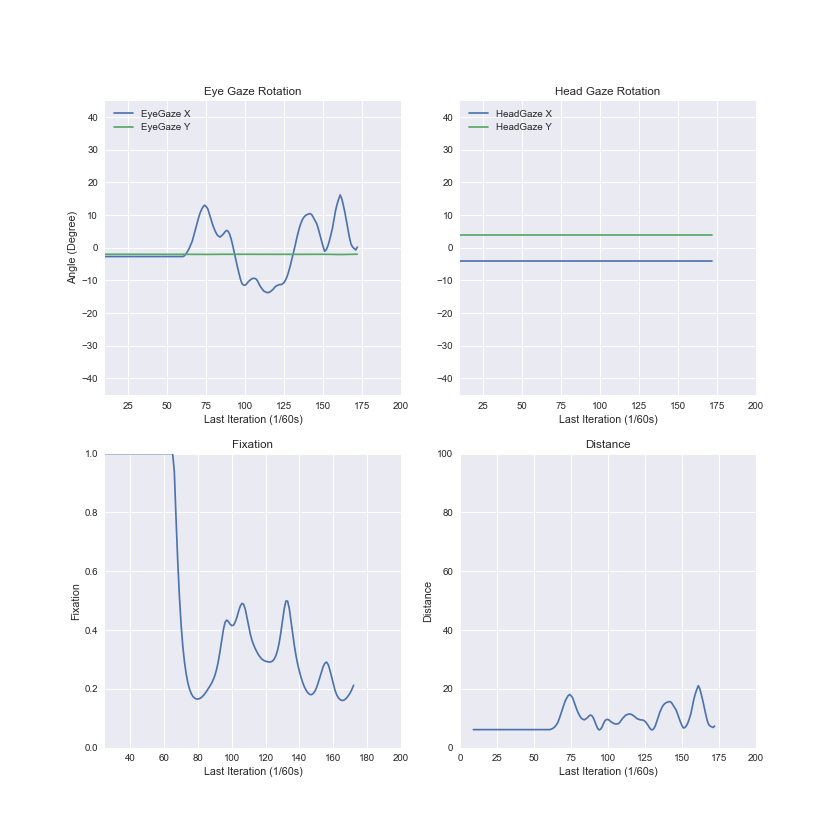

In [51]:
# Streaming
current_data = collections.deque([], current_data_size)
task = data_stream.get_stream(current_data)


def on_close(evt):
    data_stream.stop_stream(task)


# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.canvas.mpl_connect('close_event', on_close)


line1, = ax[0][0].plot([], [], label="EyeGaze X", linestyle='-')
line2, = ax[0][0].plot([], [], label="EyeGaze Y", linestyle='-')
line3, = ax[0][1].plot([], [], label="HeadGaze X", linestyle='-')
line4, = ax[0][1].plot([], [], label="HeadGaze Y", linestyle='-')

line5, = ax[1][0].plot([], [], label="Fixation", linestyle='-')
line6, = ax[1][1].plot([], [], label="Distance", linestyle='-')

ax[0][0].set_title("Eye Gaze Rotation")
ax[0][0].legend(loc="upper left")

ax[0][1].set_title("Head Gaze Rotation")
ax[0][1].legend(loc="upper left")

ax[1][0].set_title("Fixation")
ax[1][1].set_title("Distance")

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    line6.set_data([], [])
    
    ax[0][0].set_xlim(moving_average_window, 200)
    ax[0][0].set_ylim(-45, 45)
    ax[0][1].set_xlim(moving_average_window, 200)
    ax[0][1].set_ylim(-45, 45)
    
    ax[0][0].set_ylabel("Angle (Degree)")
    ax[0][0].set_xlabel("Last Iteration (1/60s)")
    ax[0][1].set_xlabel("Last Iteration (1/60s)")
        
    ax[1][0].set_xlim(moving_average_window + fixation_lookback, 200)
    ax[1][0].set_ylim(0, 1)
    ax[1][0].set_ylabel("Fixation")
    ax[1][0].set_xlabel("Last Iteration (1/60s)")
    
    ax[1][1].set_xlim(0, 200)
    ax[1][1].set_ylim(0, 100)
    ax[1][1].set_ylabel("Distance")
    ax[1][1].set_xlabel("Last Iteration (1/60s)")


last_ex = None
def update(frame):
    try:
        if len(current_data) > 0:
            df = pd.json_normalize(current_data)
            eghg.augment_cartesian_angles(df)
            eghg.augment_distances(df)
            eghg.augment_forces(df)
            eghg.augment_fixation(df)
            
            line1.set_data(df.index, df["eyeGaze.cartesian.x"].rolling(moving_average_window).mean())
            line2.set_data(df.index, df["eyeGaze.cartesian.y"].rolling(moving_average_window).mean())
            line3.set_data(df.index, df["headGaze.cartesian.x"].rolling(moving_average_window).mean())
            line4.set_data(df.index, df["headGaze.cartesian.y"].rolling(moving_average_window).mean())

            line5.set_data(df.index, df["eyeGazeHeadGaze.fixation"])
            line6.set_data(df.index, df["eyeGazeHeadGaze.distance"])
    except:
        pass



animation = FuncAnimation(fig, update, init_func=init, interval=200, blit=True)
plt.show()

## Selection

In [52]:
def eghg_augment_selection(df):
    selections = np.zeros(len(df.index))
    means = np.zeros(len(df.index))
    quantiles = np.zeros(len(df.index))
    for i in range(selection_lookback, len(df.index)):
        res = np.zeros(selection_lookback)
        selection = True
        
        values = df["eyeGazeHeadGaze.distance.x_acceleration"].values[i-selection_lookback:i]
        fixations = df["eyeGazeHeadGaze.fixation"].values[i-selection_lookback:i]
        
        mean = np.mean(values)
        quantile = np.quantile(values, selection_quantile)
        _max = np.max(values)
        _min = np.min(values)
        
        max_fixation = np.max(fixations)
        
        means[i] = mean
        quantiles[i] = quantile

        # Test mean around 0
        if abs(mean) > selection_tolerance:
            selection = False

        # Test max
        if _max < selection_target_acceleration - selection_tolerance:
            selection = False

        # Test min
        if _min > -selection_target_acceleration + selection_tolerance*2:
            selection = False
        
        # Test fixation
        if max_fixation < selection_fixation:
            selection = False
      
        if selection:
            res = np.ones(selection_lookback)
            
        for p in range(selection_lookback):
            selections[i-p] = res[-p]
            
    df["eyeGazeHeadGaze.selection"] = selections
    df["eyeGazeHeadGaze.distance.x_acceleration.means"] = means
    df["eyeGazeHeadGaze.distance.x_acceleration.quantiles"] = quantiles
    return df
    
eghg.augment_selection = eghg_augment_selection

In [53]:
eghg.augment_selection(df)

KeyError: 'eyeGazeHeadGaze.distance.x_acceleration'

<IPython.core.display.Javascript object>


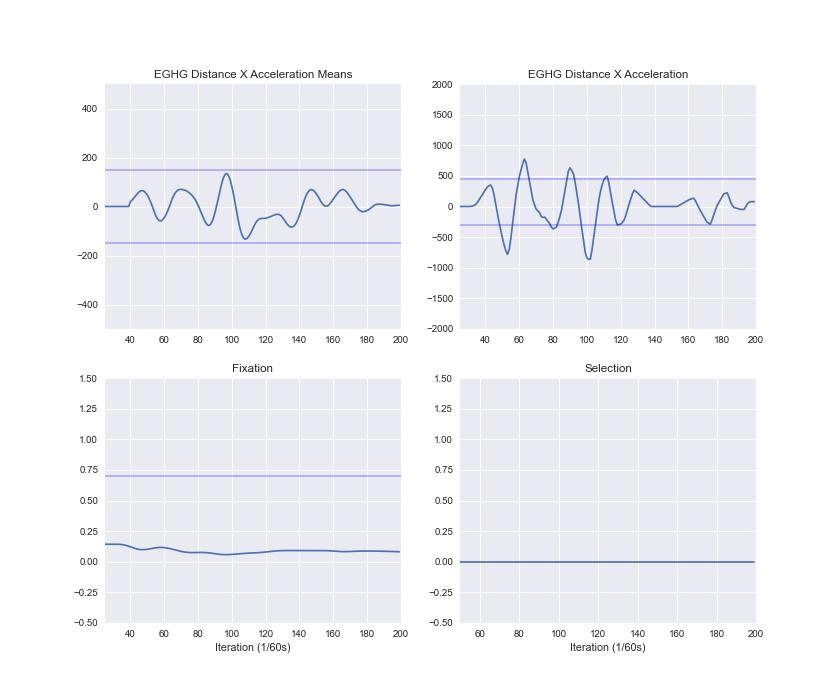

In [56]:
# Streaming
current_data = collections.deque([], current_data_size)
task = data_stream.get_stream(current_data)


def on_close(evt):
    data_stream.stop_stream(task)


# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.canvas.mpl_connect('close_event', on_close)

line1, = ax[0][0].plot([], [], label="X Velocity", linestyle='-')
ax[0][0].axhline(selection_tolerance, color='blue', lw=2, alpha=0.25)
ax[0][0].axhline(-selection_tolerance, color='blue', lw=2, alpha=0.25)

line2, = ax[0][1].plot([], [], label="X Acceleration", linestyle='-')
ax[0][1].axhline(selection_target_acceleration - selection_tolerance, color='blue', lw=2, alpha=0.25)
ax[0][1].axhline(-selection_target_acceleration + selection_tolerance*2, color='blue', lw=2, alpha=0.25)

line3, = ax[1][0].plot([], [], label="Fixation", linestyle='-')
ax[1][0].axhline(selection_fixation, color='blue', lw=2, alpha=0.25)

line4, = ax[1][1].plot([], [], label="Selection", linestyle='-')

ax[0][0].set_title("EGHG Distance X Acceleration Means")
ax[0][1].set_title("EGHG Distance X Acceleration")
ax[1][0].set_title("Fixation")
ax[1][1].set_title("Selection")


def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    
    ax[0][0].set_xlim(moving_average_window + fixation_lookback, current_data_size)
    ax[0][0].set_ylim(-500, 500)
    ax[0][1].set_xlim(moving_average_window + fixation_lookback, current_data_size)
    ax[0][1].set_ylim(-2000, 2000)    
    ax[1][0].set_xlim(moving_average_window + fixation_lookback, current_data_size)
    ax[1][0].set_ylim(-0.5, 1.5)
    ax[1][1].set_xlim(moving_average_window + selection_lookback, current_data_size)
    ax[1][1].set_ylim(-0.5, 1.5)

    ax[1][0].set_xlabel("Iteration (1/60s)")
    ax[1][1].set_xlabel("Iteration (1/60s)")


def update(frame):
    try:
        if len(current_data) > 0:
            df = pd.json_normalize(current_data)
            eghg.augment_cartesian_angles(df)
            eghg.augment_distances(df)
            eghg.augment_forces(df)
            eghg.augment_fixation(df)
            eghg.augment_selection(df)
            
            line1.set_data(df.index, df["eyeGazeHeadGaze.distance.x_acceleration.means"])
            line2.set_data(df.index, df["eyeGazeHeadGaze.distance.x_acceleration"])
            line3.set_data(df.index, df["eyeGazeHeadGaze.fixation"])
            line4.set_data(df.index, df["eyeGazeHeadGaze.selection"])
            
            ax[0][0].collections.clear()
            
            return line1, line2, line3, line4, 
    except:
        pass


animation = FuncAnimation(fig, update, init_func=init, interval=200, blit=True)
plt.show()

In [124]:
values = df["eyeGazeHeadGaze.distance.x_acceleration"].values[-selection_lookback:]
np.mean(values)
np.max(values)
np.min(values)

-18.8241691707087

In [125]:
res = np.zeros(5)
res

array([0., 0., 0., 0., 0.])

In [118]:
df["eyeGazeHeadGaze.distance"].values

array([10.22089232, 10.22089232, 10.3994518 , 10.37520595, 10.6138583 ,
       10.5572371 , 10.1872635 , 10.13120366, 10.6738788 , 10.63483413,
       10.63483413, 10.75286463, 10.75286463, 10.64612664, 10.99536702,
       11.02432529, 11.01490084, 11.25711068, 11.58386224, 11.4289715 ,
       11.54981921, 11.30831324, 11.68016416, 11.59585453, 11.83439205,
       11.83439205, 12.11433756, 12.05164288, 12.09939419, 12.98160563,
       13.02042581, 12.7824966 , 12.82180428, 12.85673219, 12.72638628,
       12.64512205, 12.67617762, 12.7797763 , 12.80407636, 12.71469243,
       12.69119421, 12.70287837, 12.70287837, 12.89825042, 12.83717073,
       12.62167191, 12.68097439, 12.68097439, 12.34383148, 12.162844  ,
       12.14399284, 12.39556581, 12.43599891, 12.39504081, 12.36561307,
       12.33402914, 12.33402914, 12.792342  , 12.75255705, 12.62231001,
       12.73795508, 12.66164695, 12.89053735, 12.84932569, 13.0549329 ,
       12.83713259, 12.9502351 , 12.96296473, 11.3087337 , 11.30

In [154]:

i = 35
values = df["eyeGazeHeadGaze.distance.x_acceleration"].values[i:i+selection_lookback]
values

array([-11.5350784 , -22.26379987,  -7.02026175,   3.33528958,
       -38.77314955, -31.33385813, -19.10573125,  -7.99255121,
        -7.63618261,   1.43353189,  -5.86351434,  -2.2377885 ,
       -12.42531486, -19.12010402,   7.09131064,   7.99680816,
         3.24710554,   0.96009834, -14.63448618,  -8.57594845,
        -0.53036639,  -0.42646358,  12.00784406,  25.63046615,
        20.18817378,  22.78654276,  10.26812527,  11.30755841,
        20.01457386,  13.29200989])

In [155]:
values = df["eyeGazeHeadGaze.distance.x_acceleration"].values[i-selection_lookback:i]
mean = np.mean(values)
_max = np.max(values)
_min = np.min(values)

In [156]:
mean

4.459168198963389

In [190]:
df["eyeGazeHeadGaze.distance.x_acceleration"].quantile(q=0.5)

0.0